In [1]:
import models
from loader import Loader
from copy import deepcopy
import torch

from edit_heuristics import FromLayerHeuristic, SingleLayerHeuristic, ActivationBased, WeightsActivationBased
from set_heuristics import SetHeuristic, SubsetSetHeuristic, SimilaritySetHeuristic

ROOT = "./data"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = f"{ROOT}/moon_classifier_mlp.pth"
DATASET_PATH = f"{ROOT}/moon_dataset.pt"
EDITSET_PATH = f"{ROOT}/moon_misclassifications.pt"
EDITED_MODEL_PATH = f"{ROOT}/moon_classifier_mlp_edited.pth"

model = models.mlp(path=MODEL_PATH)
moon_data = torch.load(DATASET_PATH)
moon_dataset = torch.utils.data.TensorDataset(moon_data['features'], moon_data['labels'])

# Test different heuristics - uncomment one at a time

# Option 1: Single layer editing
# edit_heuristic = SingleLayerHeuristic(
#     layer_idx=-1,
#     lb=-0.5,
#     ub=0.5,
# )

# Option 2: From layer editing
# edit_heuristic = FromLayerHeuristic(
#     start_layer=-1,
#     lb=-0.5,
#     ub=0.5,
# )

# Option 3: Activation-based layer selection
# edit_heuristic = ActivationBased(
#     dataset=moon_dataset,
#     lb=-0.5,
#     ub=0.5,
# )

# Option 4: Weight-level activation-based editing (FIXED VERSION)
edit_heuristic = WeightsActivationBased(
    dataset=moon_dataset,
    lb=-0.1,
    ub=0.1,
    threshold=0.9,
)

# set_heuristic = SimilaritySetHeuristic(
#     filename=EDITSET_PATH,
#     device=DEVICE,
#     dtype=torch.float32,
#     similarity_threshold=0.9999999999,
# )

set_heuristic = SubsetSetHeuristic(
    filename=EDITSET_PATH,
    indices=[0, 1, 2, 3, 4, 5],
)

print("Set heuristic inputs and labels:")
print(set_heuristic.get_inputs_and_labels())

loader = Loader(
    model=model,
    edit_heuristic=edit_heuristic,
    set_heuristic=set_heuristic,
    dataset=moon_dataset,
)

print(f"\nTesting {edit_heuristic.__class__.__name__} heuristic...")
loader.edit_and_test_model()
loader.save_model(EDITED_MODEL_PATH)

print(f"Model saved to {EDITED_MODEL_PATH}")

[12:46:05] INFO     Set parameter Username

           INFO     Set parameter LicenseID to value 2659342

Set heuristic inputs and labels:
(tensor([[ 0.1846,  0.3510],
        [ 0.3290,  0.5317],
        [-0.0871,  0.5121],
        [ 1.1133,  0.0938],
        [ 0.0104,  0.6095],
        [ 0.1334,  0.3674]]), tensor([1, 1, 1, 0, 1, 1]))

Testing WeightsActivationBased heuristic...


[12:46:06] INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9600, Loss: 0.2487
Model saved to ./data/moon_classifier_mlp_edited.pth
Model saved to ./data/moon_classifier_mlp_edited.pth


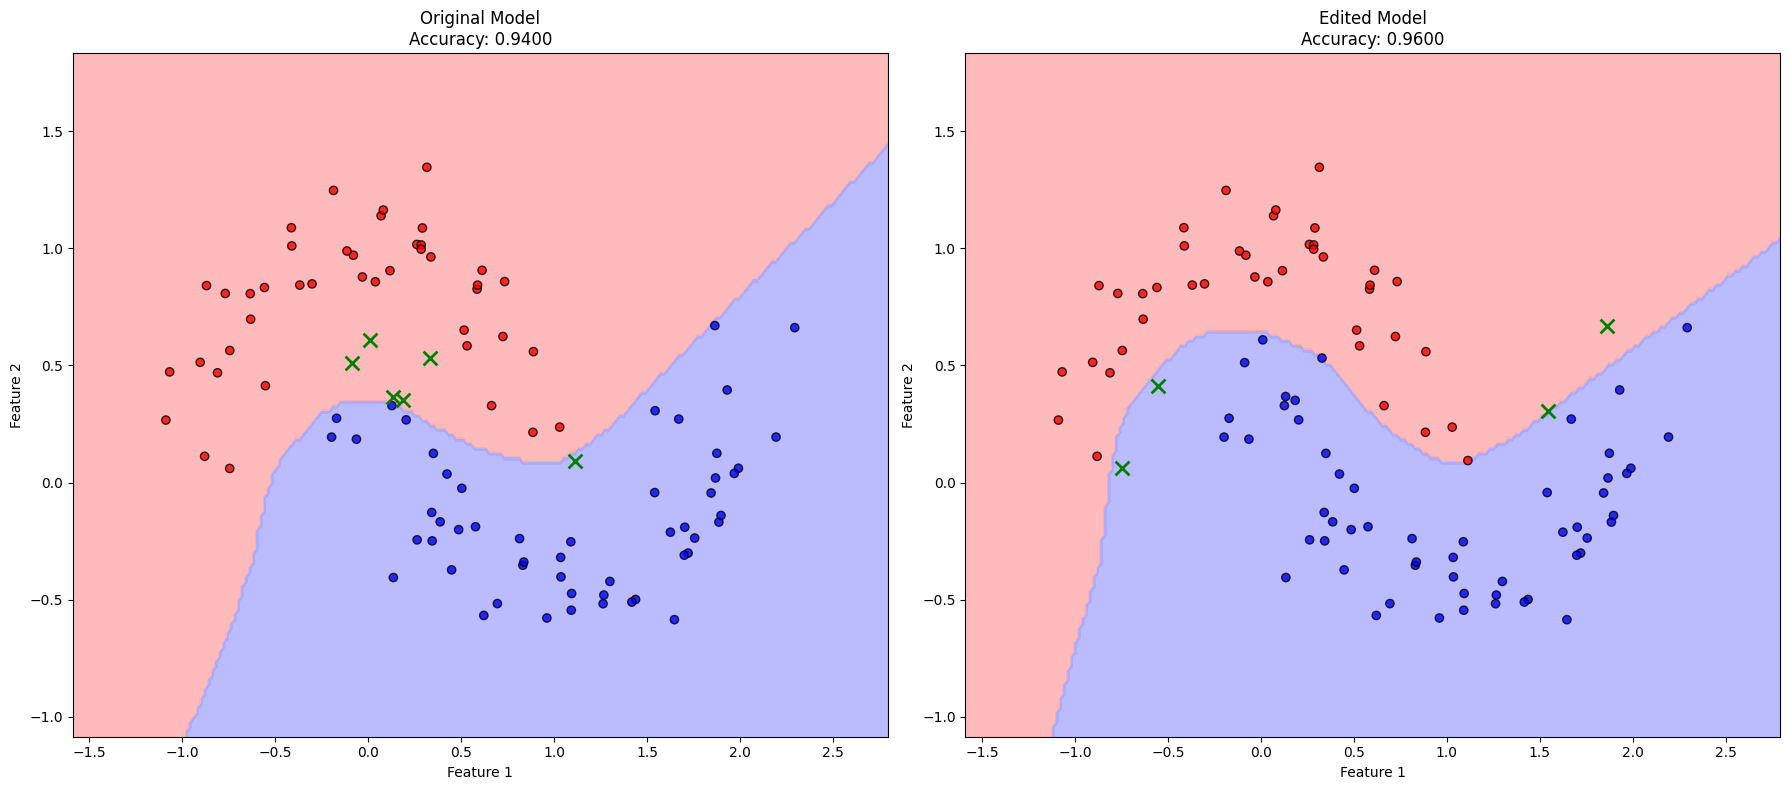

Original model correctness: 0.9400
Original model accuracy: 94 / 100
Edited model correctness: 0.9600
Edited model accuracy: 96 / 100
Number of samples fixed by editing: 6
Number of new errors introduced: 4


In [2]:
from matplotlib.colors import ListedColormap
import numpy as np
import torch

import matplotlib.pyplot as plt

def compare_models_decision_boundary(original_model, edited_model, X, y):
    """
    Compare decision boundaries and misclassifications of original and edited models.
    
    Args:
        original_model: The original MLP model
        edited_model: The edited MLP model
        X: Input features tensor/numpy array
        y: True labels tensor/numpy array
    """
    # Convert inputs to numpy if they're tensors
    if isinstance(X, torch.Tensor):
        X = X.numpy()
    if isinstance(y, torch.Tensor):
        y = y.numpy()
    
    # Create a mesh grid for decision boundary visualization
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    mesh_input = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    
    # Set up the figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Loop through both models
    for i, (title, model) in enumerate([('Original Model', original_model), ('Edited Model', edited_model)]):
        # Get predictions for the mesh
        with torch.no_grad():
            mesh_output = model(mesh_input)
            Z = torch.argmax(mesh_output, dim=1).reshape(xx.shape).detach().numpy()
            
            # Get predictions for the test points
            outputs = model(torch.FloatTensor(X))
            _, predicted = torch.max(outputs.data, 1)
        
        # Convert to numpy
        predicted = predicted.numpy()
        
        # Plot decision boundary
        axes[i].contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)
        
        # Plot correct classifications
        correct_idx = (predicted == y)
        axes[i].scatter(X[correct_idx, 0], X[correct_idx, 1], 
                  c=y[correct_idx], cmap=ListedColormap(['#FF0000', '#0000FF']), 
                  edgecolors='k', alpha=0.8)
        
        # Plot misclassifications with green X
        misclass_idx = (predicted != y)
        axes[i].scatter(X[misclass_idx, 0], X[misclass_idx, 1], 
                  c='green', marker='x', s=100, linewidths=2)
        
        # Calculate and display accuracy
        accuracy = (predicted == y).mean()
        axes[i].set_title(f"{title}\nAccuracy: {accuracy:.4f}")
        axes[i].set_xlabel('Feature 1')
        axes[i].set_ylabel('Feature 2')
    
    plt.tight_layout()
    plt.show()
    
    # Print the number of misclassifications for each model
    with torch.no_grad():
        original_preds = torch.argmax(original_model(torch.FloatTensor(X)), dim=1).numpy()
        edited_preds = torch.argmax(edited_model(torch.FloatTensor(X)), dim=1).numpy()
        
        original_misclass = (original_preds != y).sum()
        edited_misclass = (edited_preds != y).sum()
        
        print(f"Original model correctness: {(original_preds == y).mean():.4f}")
        print(f"Original model accuracy: {len(y) - original_misclass} / {len(y)}")
        print(f"Edited model correctness: {(edited_preds == y).mean():.4f}")
        print(f"Edited model accuracy: {len(y) - edited_misclass} / {len(y)}")
        
        # Show which samples were fixed by editing
        fixed_samples = np.where((original_preds != y) & (edited_preds == y))[0]
        new_errors = np.where((original_preds == y) & (edited_preds != y))[0]
        
        print(f"Number of samples fixed by editing: {len(fixed_samples)}")
        print(f"Number of new errors introduced: {len(new_errors)}")

# Load the original model
original_model = models.mlp(path=MODEL_PATH)

# Load the edited model
edited_model = deepcopy(model)
edited_model.load_state_dict(torch.load(EDITED_MODEL_PATH, map_location=DEVICE))

# Get the test data features and labels from the moon_dataset
X = moon_data['features']
y = moon_data['labels']

# Compare the models
compare_models_decision_boundary(original_model, edited_model, X, y)

Testing all combinations of heuristics...

Testing: SingleLayer + SubsetSetHeuristic


[12:46:09] INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.8800, Loss: 0.6571
Accuracy: 0.8800

Testing: SingleLayer + SimilaritySetHeuristic


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9500, Loss: 0.1484
Accuracy: 0.9500

Testing: FromLayer + SubsetSetHeuristic


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.8800, Loss: 0.6571
Accuracy: 0.8800

Testing: FromLayer + SimilaritySetHeuristic


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9500, Loss: 0.1484
Accuracy: 0.9500

Testing: ActivationBased + SubsetSetHeuristic


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.8800, Loss: 0.6571
Accuracy: 0.8800

Testing: ActivationBased + SimilaritySetHeuristic


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9500, Loss: 0.1484
Accuracy: 0.9500

Testing: WeightsActivationBased + SubsetSetHeuristic


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9600, Loss: 0.2487
Accuracy: 0.9600

Testing: WeightsActivationBased + SimilaritySetHeuristic


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9500, Loss: 0.1484
Accuracy: 0.9500

Best combination: WeightsActivationBased + SubsetSetHeuristic with accuracy: 0.9600


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:93                                                                                   │
│                                                                                                  │
│    90                                                                                            │
│    91 # Plot all edited models                                                                   │
│    92 for i, result in enumerate(results):                                                       │
│ ❱  93 │   ax = axes[i + 1]                                                                       │
│    94 │   model = result['model']                                                                │
│    95 │                                                                                          │
│    96 │   with torch.no_grad():                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 8 is out of bounds for axis 0 with size 8

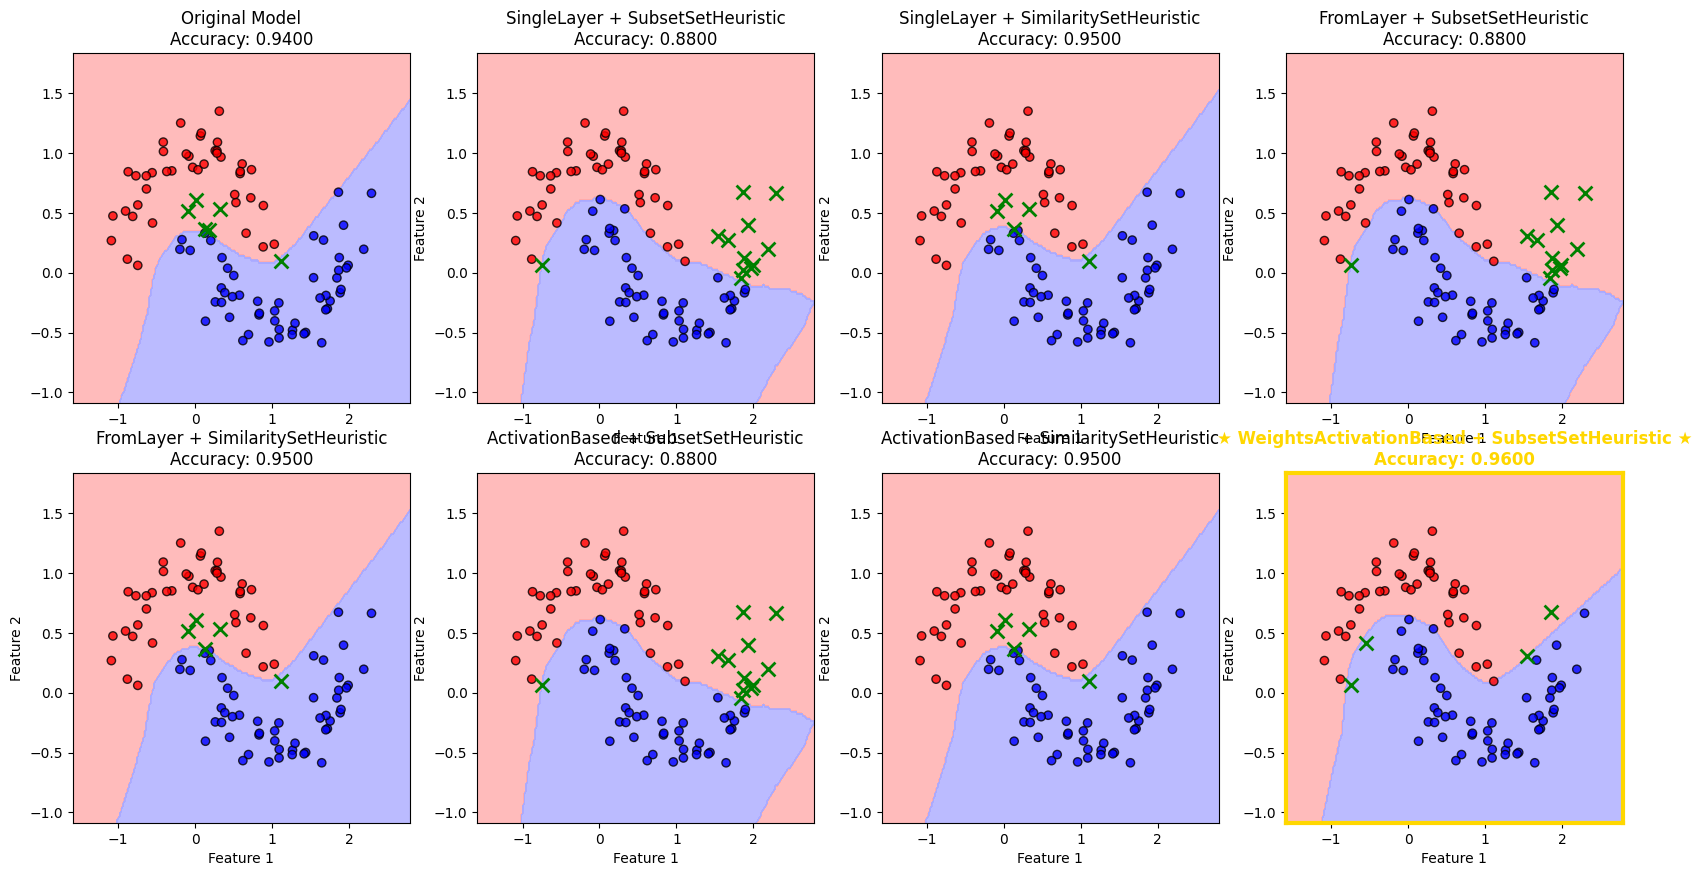

In [3]:
from itertools import product

# Test all possible combinations of heuristics

# Define all heuristic options
edit_heuristics_options = [
    ("SingleLayer", SingleLayerHeuristic(layer_idx=-1, lb=-0.5, ub=0.5)),
    ("FromLayer", FromLayerHeuristic(start_layer=-1, lb=-0.5, ub=0.5)),
    ("ActivationBased", ActivationBased(dataset=moon_dataset, lb=-0.5, ub=0.5)),
    ("WeightsActivationBased", WeightsActivationBased(dataset=moon_dataset, lb=-0.1, ub=0.1, threshold=0.9))
]

set_heuristics_options = [
    ("SubsetSetHeuristic", SubsetSetHeuristic(filename=EDITSET_PATH, indices=[0, 1, 2, 3, 4, 5])),
    ("SimilaritySetHeuristic", SimilaritySetHeuristic(filename=EDITSET_PATH, device=DEVICE, dtype=torch.float32, similarity_threshold=0.9999999999))
]

# Store results
results = []

print("Testing all combinations of heuristics...")
for (edit_name, edit_heur), (set_name, set_heur) in product(edit_heuristics_options, set_heuristics_options):
    try:
        print(f"\nTesting: {edit_name} + {set_name}")
        
        # Create loader with current combination
        test_loader = Loader(
            model=deepcopy(original_model),
            edit_heuristic=edit_heur,
            set_heuristic=set_heur,
            dataset=moon_dataset,
        )
        
        # Edit and test model
        test_loader.edit_and_test_model()
        
        # Get edited model predictions
        with torch.no_grad():
            outputs = test_loader.model(X)
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted.numpy() == y.numpy()).mean()
        
        results.append({
            'edit_heuristic': edit_name,
            'set_heuristic': set_name,
            'model': deepcopy(test_loader.model),
            'accuracy': accuracy,
            'combination': f"{edit_name} + {set_name}"
        })
        
        print(f"Accuracy: {accuracy:.4f}")
        
    except Exception as e:
        print(f"Error with {edit_name} + {set_name}: {str(e)}")

# Find best combination
best_result = max(results, key=lambda x: x['accuracy'])
print(f"\nBest combination: {best_result['combination']} with accuracy: {best_result['accuracy']:.4f}")

# Create consolidated visualization
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Parameters for visualization
h = 0.02
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
mesh_input = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

# Plot original model first
with torch.no_grad():
    mesh_output = original_model(mesh_input)
    Z = torch.argmax(mesh_output, dim=1).reshape(xx.shape).detach().numpy()
    original_outputs = original_model(X)
    _, original_predicted = torch.max(original_outputs.data, 1)

original_predicted = original_predicted.numpy()
original_accuracy = (original_predicted == y.numpy()).mean()

axes[0].contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)
correct_idx = (original_predicted == y.numpy())
axes[0].scatter(X[correct_idx, 0], X[correct_idx, 1], 
                c=y.numpy()[correct_idx], cmap=ListedColormap(['#FF0000', '#0000FF']), 
                edgecolors='k', alpha=0.8)
misclass_idx = (original_predicted != y.numpy())
axes[0].scatter(X[misclass_idx, 0], X[misclass_idx, 1], 
                c='green', marker='x', s=100, linewidths=2)
axes[0].set_title(f"Original Model\nAccuracy: {original_accuracy:.4f}")

# Plot all edited models
for i, result in enumerate(results):
    ax = axes[i + 1]
    model = result['model']
    
    with torch.no_grad():
        mesh_output = model(mesh_input)
        Z = torch.argmax(mesh_output, dim=1).reshape(xx.shape).detach().numpy()
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
    
    predicted = predicted.numpy()
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)
    
    # Plot correct classifications
    correct_idx = (predicted == y.numpy())
    ax.scatter(X[correct_idx, 0], X[correct_idx, 1], 
               c=y.numpy()[correct_idx], cmap=ListedColormap(['#FF0000', '#0000FF']), 
               edgecolors='k', alpha=0.8)
    
    # Plot misclassifications
    misclass_idx = (predicted != y.numpy())
    ax.scatter(X[misclass_idx, 0], X[misclass_idx, 1], 
               c='green', marker='x', s=100, linewidths=2)
    
    # Highlight best model with gold border
    if result == best_result:
        for spine in ax.spines.values():
            spine.set_edgecolor('gold')
            spine.set_linewidth(3)
        title_color = 'gold'
        title = f"★ {result['combination']} ★\nAccuracy: {result['accuracy']:.4f}"
    else:
        title_color = 'black'
        title = f"{result['combination']}\nAccuracy: {result['accuracy']:.4f}"
    
    ax.set_title(title, color=title_color, fontweight='bold' if result == best_result else 'normal')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

# Remove empty subplots
for i in range(len(results) + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Comparison of All Heuristic Combinations\n(Best model highlighted with gold border)', 
             fontsize=16, y=1.02)
plt.show()

# Print detailed comparison
print("\n" + "="*80)
print("DETAILED RESULTS COMPARISON")
print("="*80)
print(f"{'Combination':<35} {'Accuracy':<10} {'Improvement':<12}")
print("-"*80)
print(f"{'Original Model':<35} {original_accuracy:<10.4f} {'baseline':<12}")
for result in sorted(results, key=lambda x: x['accuracy'], reverse=True):
    improvement = result['accuracy'] - original_accuracy
    improvement_str = f"+{improvement:.4f}" if improvement > 0 else f"{improvement:.4f}"
    marker = " ★ BEST" if result == best_result else ""
    print(f"{result['combination']:<35} {result['accuracy']:<10.4f} {improvement_str:<12}{marker}")